<a href="https://colab.research.google.com/github/udayLab/PAMI/blob/main/notebooks/georeferencedPeriodicFrequentPattern/basic/STEclat.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Finding Geo-Referenced (Spatial) Partial Periodic patterns in Temporal Databases using STEclat

This tutorial has two parts. In the first part, we describe the basic approach to find Geo-Referenced (Spatial) Partial Periodic patterns in a temporal database using the STEclat algorithm. In the final part, we describe an advanced approach, where we evaluate the STEclat algorithm on a dataset at different minimum support threshold values.
***

# Prerequisites:

1.   Installing the PAMI library

In [ ]:
!pip install -U pami #install the pami repository

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 835.0/835.0 kB 7.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Created wheel for JsonForm: filename=JsonForm-0.0.2-py3-none-any.whl size=3313 sha256=bb7161b013faa1694f0ddcfee32113b3dfac7ddbb66a711db06bbf9948489ca7
  Stored in directory: /root/.cache/pip/wheels/b6/e5/87/11026246d3bd4ad67c0615682d2d6748bbd9a40ac0490882bd
  Created wheel for JsonSir: filename=JsonSir-0.0.2-py3-none-any.whl size=4750 sha256=5fe4e741a5dbe0776d8c723eae41ca03b45b3d22247f44513bafbbdf24bec538
  Stored in directory: /root/.cache/pip/wheels/1d/4c/d3/4d9757425983b43eb709be1043d82cd03fb863ce5f56f117e6
Successfully built JsonForm JsonSir


2.   Downloading a sample dataset

In [ ]:
!wget -nc https://u-aizu.ac.jp/~udayrage/datasets/temporalDatabases/Temporal_T10I4D100K.csv #download a sample temporal database

--2023-09-08 16:54:40--  https://u-aizu.ac.jp/~udayrage/datasets/temporalDatabases/Temporal_T10I4D100K.csv
Resolving u-aizu.ac.jp (u-aizu.ac.jp)... 150.95.161.176, 150.31.244.160
Connecting to u-aizu.ac.jp (u-aizu.ac.jp)|150.95.161.176|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4606762 (4.4M) [text/csv]
Saving to: ‘Temporal_T10I4D100K.csv’

Temporal_T10I4D100K 100%[===================>]   4.39M  1.07MB/s    in 4.1s    

2023-09-08 16:54:45 (1.07 MB/s) - ‘Temporal_T10I4D100K.csv’ saved [4606762/4606762]



3.   Printing few lines of a dataset to know its format.

In [ ]:
!head -2 Temporal_T10I4D100K.csv

1	25	52	164	240	274	328	368	448	538	561	630	687	730	775	825	834
2	39	120	124	205	401	581	704	814	825	834


format: every row contains items seperated by a seperator.

Example:

item1 item2 item3 item4

item1 item4 item6
***

## Part 1: Finding Geo-Referenced (Spatial) Partial Periodic patterns using STEclat

### Step 1: Understanding the statistics of a database to choose an appropriate minimum support (minSup) value.

In [ ]:
#import the class file
import PAMI.extras.dbStats.TemporalDatabase as stats

#specify the file name
inputFile = 'Temporal_T10I4D100K.csv'

#initialize the class
obj=stats.TemporalDatabase(inputFile,sep='\t')

#execute the class
obj.run()

#Printing each of the database statistics
print(f'Database size : {obj.getDatabaseSize()}')
print(f'Total number of items : {obj.getTotalNumberOfItems()}')
print(f'Database sparsity : {obj.getSparsity()}')
print(f'Minimum Transaction Size : {obj.getMinimumTransactionLength()}')
print(f'Average Transaction Size : {obj.getAverageTransactionLength()}')
print(f'Maximum Transaction Size : {obj.getMaximumTransactionLength()}')
print(f'Standard Deviation Transaction Size : {obj.getStandardDeviationTransactionLength()}')
print(f'Variance in Transaction Sizes : {obj.getVarianceTransactionLength()}')

#saving the distribution of items' frequencies and transactional lengths
itemFrequencies = obj.getSortedListOfItemFrequencies()
transactionLength = obj.getTransanctionalLengthDistribution()
obj.save(itemFrequencies, 'itemFrequency.csv')
obj.save(transactionLength, 'transactionSize.csv')

#Alternative apporach to print all of the database statistics and plot them
# obj.printStats()
# obj.plotGraphs()

Database size : 99913
Total number of items : 870
Database sparsity : 0.9883887027691103
Minimum Transaction Size : 1
Average Transaction Size : 10.10182859087406
Maximum Transaction Size : 29
Standard Deviation Transaction Size : 3.667115963877195
Variance in Transaction Sizes : 13.447874088362232


### Step 2: Draw the item's frequency graph and transaction length's distribution graphs for more information

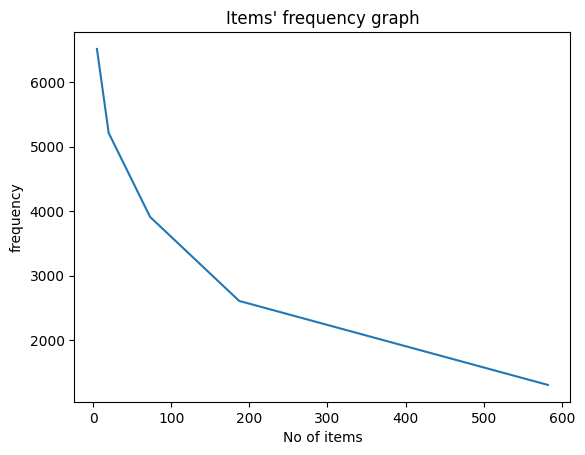

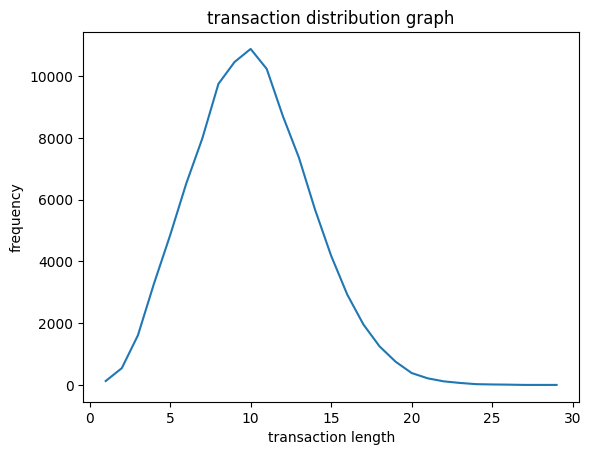

In [ ]:
import PAMI.extras.graph.plotLineGraphFromDictionary as plt

itemFrequencies = obj.getFrequenciesInRange()
transactionLength = obj.getTransanctionalLengthDistribution()
plt.plotLineGraphFromDictionary(itemFrequencies, end = 100, title = 'Items\' frequency graph', xlabel = 'No of items', ylabel= 'frequency')
plt.plotLineGraphFromDictionary(transactionLength, end = 100, title = 'transaction distribution graph', xlabel = 'transaction length', ylabel = 'frequency')

### Step 3: Choosing an appropriate *minSup* value

_Observations_

  1. The input dataset is sparse as the sparsity value is 0.988 (=98.8%)
  2. Many items have low frequencies as seen in the items' frequency graph
  3. The dataset is not high dimensional as the inverted curve is around 10.

  Based on the above observations, let us choose a _minSup_ value of 100 (in count). We can increase or decrease the _minSup_ based on the number of patterns being generated.

In [ ]:
minimumSupportCount = 100  #minSup is specified in count. However, the users can also specify minSup between 0 and 1.
neighborFile = '/content/t10_neighbours.txt'
maxmunPeriodCount = 4000 #user can specify different value.

### Step 4: Mining Geo-Referenced (Spatial) Partial Periodic patterns using STEclat

In [ ]:
from PAMI.georeferencedPartialPeriodicPattern.basic import STEclat  as alg #import the algorithm

obj = alg.STEclat(iFile=inputFile, minPS=minimumSupportCount, maxIAT=maxmunPeriodCount, nFile=neighborFile, sep='\t') #initialize
obj.mine()            #start the mining process

obj.save('partialPeriodicPatternsMinSupCount100.txt') #save the patterns


frequentPatternsDF= obj.getPatternsAsDataFrame() #get the generated frequent patterns as a dataframe
print('Total No of patterns: ' + str(frequentPatternsDF)) #print the total number of patterns
print('Runtime: ' + str(obj.getRuntime())) #measure the runtime

print('Memory (RSS): ' + str(obj.getMemoryRSS()))
print('Memory (USS): ' + str(obj.getMemoryUSS()))

Spatial Periodic Frequent patterns were generated successfully using SpatialEclat algorithm
Total No of patterns:     Patterns  periodicSupport
0       368              7817
1       529              7050
2       829              6800
3       766              6257
4       722              5836
..       ...              ...
790      62               108
791     426               107
792     856               107
793     102               107
794     199               107

[795 rows x 2 columns]
Runtime: 3.1638286113739014
Memory (RSS): 346140672
Memory (USS): 299503616


### Step 5: Investigating the generated patterns

Open the pattern's file and investigate the generated patterns. If the generated patterns were interesting, use them; otherwise, redo the Steps 3 and 4 with a different _minSup_ value.

In [ ]:
!head 'partialPeriodicPatternsMinSupCount100.txt'

368: 7817 
529: 7050 
829: 6800 
766: 6257 
722: 5836 
354: 5828 
684: 5402 
217: 5364 
494: 5095 
419: 5046 


The storage format is: _periodicFrequentPattern:support_
***

## Part 2: Evaluating the STEclat algorithm on a dataset at different minSup values

### Step 1: Import the libraries and specify the input parameters

In [ ]:
#Import the libraries
from PAMI.georeferencedPartialPeriodicPattern.basic import STEclat  as alg  #import the algorithm
import pandas as pd

#Specify the input parameters
inputFile = 'Temporal_T10I4D100K.csv'
seperator='\t'
neighborFile = '/content/t10_neighbours.txt'
maximunPeriodCount = 4000
minimumSupportCountList = [100, 200, 300, 400, 500]
#minimumSupport can also specified between 0 to 1. E.g., minSupList = [0.005, 0.006, 0.007, 0.008, 0.009]

### Step 2: Create a data frame to store the results of STEclat

In [ ]:
result = pd.DataFrame(columns=['algorithm', 'minSup', 'maximunPeriodCount', 'patterns', 'runtime', 'memory'])
#initialize a data frame to store the results of STEclat algorithm

### Step 3: Execute the algorithm at different minSup values

In [ ]:
for minSupCount in minimumSupportCountList:
    obj = alg.STEclat(iFile=inputFile, minPS=minSupCount, maxIAT=maximunPeriodCount, nFile=neighborFile, sep=seperator)
    obj.mine()
    #store the results in the data frame
    result.loc[result.shape[0]] = ['STEclat', minSupCount, maximunPeriodCount, len(obj.getPatterns()), obj.getRuntime(), obj.getMemoryRSS()]

Spatial Periodic Frequent patterns were generated successfully using SpatialEclat algorithm
Spatial Periodic Frequent patterns were generated successfully using SpatialEclat algorithm
Spatial Periodic Frequent patterns were generated successfully using SpatialEclat algorithm
Spatial Periodic Frequent patterns were generated successfully using SpatialEclat algorithm
Spatial Periodic Frequent patterns were generated successfully using SpatialEclat algorithm


### Step 4: Print the Result

In [ ]:
print(result)

  algorithm  minSup  maximunPeriodCount  patterns   runtime     memory
0   STEclat     100                4000       795  1.728645  348770304
1   STEclat     200                4000       741  1.696349  349192192
2   STEclat     300                4000       692  1.653258  349970432
3   STEclat     400                4000       629  1.547991  350089216
4   STEclat     500                4000       569  2.952726  350015488


### Step 5: Visualizing the results

<Axes: xlabel='minSup'>

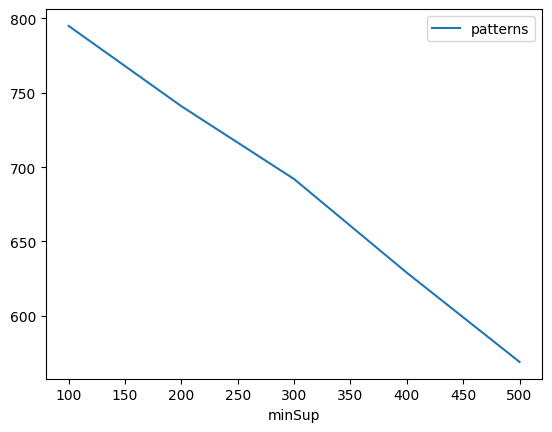

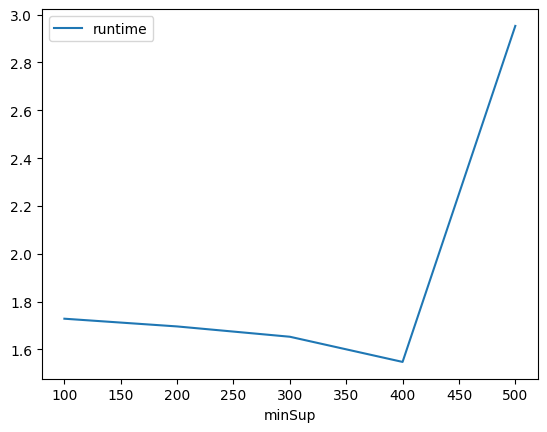

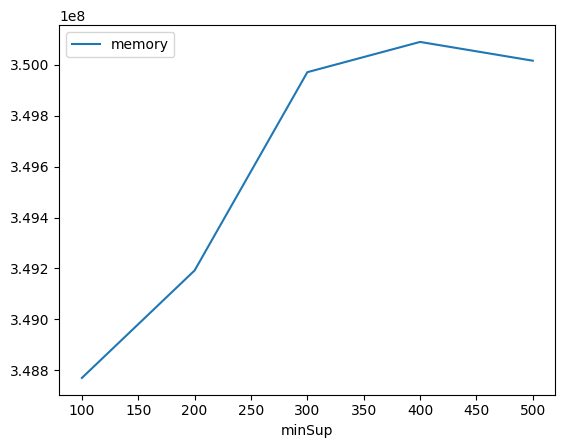

In [ ]:
result.plot(x='minSup', y='patterns', kind='line')
result.plot(x='minSup', y='runtime', kind='line')
result.plot(x='minSup', y='memory', kind='line')

#Graphs can be improved further by using additional packages, such as plotly and matplotlib